**Denoising using ResNet & ResNet vs No Skip net**

Importing the important libraries

In [ ]:
import keras
import copy
import json
import numpy as np
from keras.datasets import cifar10
from matplotlib import pyplot as plt

Using TensorFlow backend.


Loading the train and test data of CIFAR 10

Scaled the images to [0,1]

In [ ]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = cifar10.load_data()

x_train   = copy.deepcopy(x_train_org[0:10000])
x_test    = copy.deepcopy(x_test_org[0:1000])

y_train   = copy.deepcopy(y_train_org[0:10000])
y_test    = copy.deepcopy(y_train_org[0:1000])

x_train   = x_train.astype('float32')
x_test    = x_test.astype('float32')
x_train   /= 255
x_test    /=255
y_train_1 = keras.utils.to_categorical(y_train, 10)
y_test_1  = keras.utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (10000, 32, 32, 3)
10000 train samples
1000 test samples


Making a deep copy for adding noise to the train and test data

In [ ]:
x_train_noisy = copy.deepcopy(x_train)
x_test_noisy  = copy.deepcopy(x_test)

Adding gaussian noise with mean = 0 and SD = 0.1

In [ ]:
x_train_noisy = x_train_noisy + np.random.normal(0,0.1,x_train_noisy.shape)
x_test_noisy  = x_test_noisy + np.random.normal(0,0.1,x_test_noisy.shape)

Displaying 4 images from the original training set and the noisy set

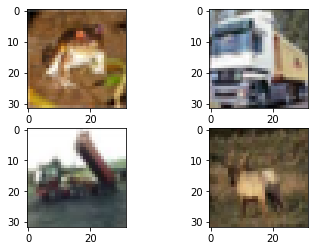

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


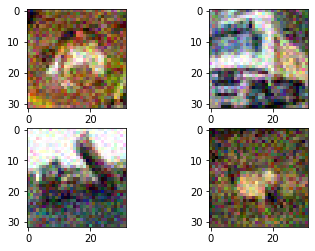

In [ ]:
for index in range(0,4):
  plt.subplot(220 + 1 + index)
  plt.imshow(x_train[index])

plt.show()

for index in range(0,4):
  plt.subplot(220 + 1 + index)
  plt.imshow(x_train_noisy[index])

plt.show()

Build a ResNet Model

In [ ]:
from keras.models import Model
from keras.layers import Add, Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.optimizers import Adam

In [ ]:
def resBlock(input_tensor, num_channels):
  conv1 = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
  relu  = Activation('relu')(conv1)
  conv2 = Conv2D(num_channels,(3,3),padding='same')(relu)
  add   = Add()([input_tensor, conv2])

  output_tensor = Activation('relu')(add)
  return output_tensor

def build_resnet_model(height,width,num_channels,num_res_blocks):
    inp       = Input(shape=(height,width,3))
    conv      = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)

    for i in np.arange(0,num_res_blocks):
        block_out = resBlock(block_out, num_channels)

    conv_m2   = Conv2D (3,(3,3),padding='same')(block_out)
    add_m2    = Add()([inp, conv_m2])
    model     = Model(inputs =inp,outputs = add_m2)

    return model

model = build_resnet_model(32,32,32,5)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        activation_1[0][0]               
____________________________________________________________________________________________

Train the resnet model

In [ ]:
model.compile(optimizer= Adam(beta_2 = 0.9),loss='mean_squared_error',metrics=['mse'])

history = model.fit(x_train_noisy, x_train, 128, 25, 1, validation_data=(x_test_noisy,x_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/25
10000/10000 [==============================] - 212s 21ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 2/25
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/25
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/25
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/25
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/25
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/25
10000/10000 [==============================] - 211s 21ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0

In [ ]:
response = model.predict(x_test_noisy)

Show some of the denoised examples.
Images from left to right are - Noisy image, original image, denoised image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


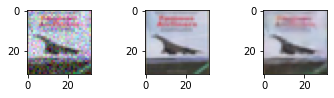

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


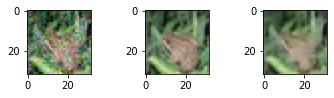

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


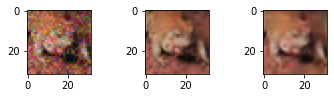

In [ ]:
for index in range(3,6):
  plt.subplot(330 + 1)
  plt.imshow(x_test_noisy[index])
  plt.subplot(330 + 2)
  plt.imshow(x_test[index])
  plt.subplot(330 + 3)
  plt.imshow(response[index])
  plt.show()

The distribution of noise on the test set.

In [ ]:
avg_mse   = []
avg_mean  = []
avg_sd    = []

for index in range(0,1000):
  avg_mean.append(np.mean(x_test[index] - response[index]))
  avg_mse.append(np.mean((x_test[index] - response[index])**2))
  avg_sd.append(np.std(x_test[index] - response[index]))

print("Mean:", np.sum(avg_mean)/1000)
print("MSE:", np.sum(avg_mse)/1000)
print("SD:", np.sum(avg_sd)/1000)

Mean: -0.0017345898151397705
MSE: 0.001565335988998413
SD: 0.03908758544921875


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


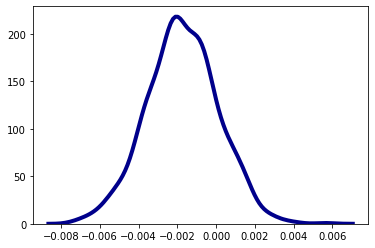

In [ ]:
from pandas import Series
import seaborn as sns

sns.distplot(avg_mean, hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Model without skip connections

In [ ]:
def noSkipBlock(input_tensor, num_channels):
  conv1 = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
  relu  = Activation('relu')(conv1)
  conv2 = Conv2D(num_channels,(3,3),padding='same')(relu)

  output_tensor = Activation('relu')(conv2)
  return output_tensor

def build_noskip_model(height,width,num_channels,num_res_blocks):
    inp       = Input(shape=(height,width,3))
    conv      = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)

    for i in np.arange(0,num_res_blocks):
        block_out = noSkipBlock(block_out, num_channels)

    conv_m2   = Conv2D (3,(3,3),padding='same')(block_out)
    model     = Model(inputs =inp,outputs = conv_m2)

    return model

modelNoSkip = build_noskip_model(32,32,32,5)
modelNoSkip.name = 'NoSkipModel'
modelNoSkip.summary()

Model: "NoSkipModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        

In [ ]:
modelNoSkip.compile(optimizer= Adam(beta_2 = 0.9),loss='mean_squared_error',metrics=['mse'])

historyNoSkip = modelNoSkip.fit(x_train_noisy, x_train, 128, 25, 1, validation_data=(x_test_noisy,x_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/25
10000/10000 [==============================] - 210s 21ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 2/25
10000/10000 [==============================] - 209s 21ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/25
10000/10000 [==============================] - 209s 21ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 4/25
10000/10000 [==============================] - 210s 21ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/25
10000/10000 [==============================] - 210s 21ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 6/25
10000/10000 [==============================] - 210s 21ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/25
10000/10000 [==============================] - 210s 21ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0

In [ ]:
response_noSkip = modelNoSkip.predict(x_test_noisy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


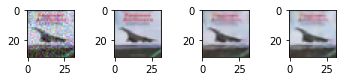

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


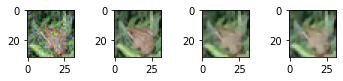

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


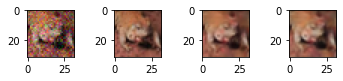

In [ ]:
for index in range(3,6):
  plt.subplot(440 + 1)
  plt.imshow(x_test_noisy[index])
  plt.subplot(440 + 2)
  plt.imshow(x_test[index])
  plt.subplot(440 + 3)
  plt.imshow(response[index])
  plt.subplot(440 + 4)
  plt.imshow(response_noSkip[index])
  plt.show()

In [ ]:
noskip_avg_mse   = []
noskip_avg_mean  = []
noskip_avg_sd    = []

for index in range(0,1000):
  noskip_avg_mean.append(np.mean(x_test[index] - response_noSkip[index]))
  noskip_avg_mse.append(np.mean((x_test[index] - response_noSkip[index])**2))
  noskip_avg_sd.append(np.std(x_test[index] - response_noSkip[index]))

print("Mean:", np.sum(noskip_avg_mean)/1000)
print("MSE:", np.sum(noskip_avg_mse)/1000)
print("SD:", np.sum(noskip_avg_sd)/1000)

Mean: -0.016421321868896485
MSE: 0.002044218063354492
SD: 0.04137003707885742


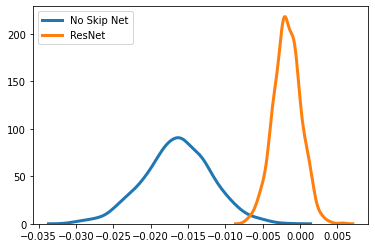

In [ ]:
sns.distplot(noskip_avg_mean, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
             label='No Skip Net')

sns.distplot(avg_mean, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
             label = 'ResNet')

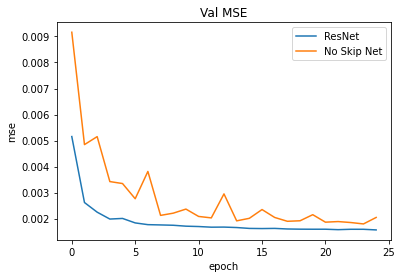

In [ ]:
#Resnet = [0.0027,0.0022,0.0020,0.0019,0.0018,0.0018,0.0017,0.0017,0.0017,0.0017,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0015,0.0015]

plt.plot(history.history['val_mse'])
plt.plot(historyNoSkip.history['val_mse'])
plt.title('Val MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['ResNet', 'No Skip Net'], loc='upper right')
plt.show()